In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# opening the image

In [2]:
def open_image(path):
    img = Image.open('slider_puffin_before_mobile.jpg')
    arr = np.array(img)
    return img,arr

In [3]:
img,arr=open_image('slider_puffin_before_mobile.jpg')

In [4]:
arr.shape

(800, 800, 3)

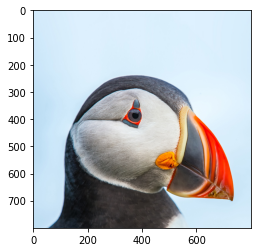

In [5]:
plt.imshow(arr)

# Converting RGB to YCbCr

In [6]:
def convert_rgb_to_ycbcr(img):
    return np.array(img.convert('YCbCr'))

In [7]:
newimg=convert_rgb_to_ycbcr(img)

In [8]:
newimg.shape

(800, 800, 3)

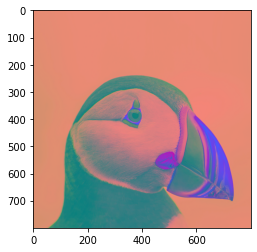

In [9]:
plt.imshow(newimg)

# DCT (Discrete Cosine Transform) : 

In [10]:
from scipy.fftpack import dct, idct

In [11]:
def dct_on_block(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
def dct_on_image(img):
    ans=np.zeros(img.shape)
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            tmp_block=img[i:i+8,j:j+8]
            ans[i:i+8,j:j+8]=dct_on_block(tmp_block)
    return ans            

# applying DCT on YCbCr converted img

In [12]:
dct_img=dct_on_image(newimg)

In [13]:
dct_img.shape

(800, 800, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


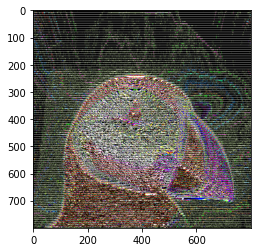

In [14]:
plt.imshow(dct_img)

# Quantizing DCT applied image with quantization matrix

In [15]:
quantization_matrix=np.zeros((8,8))
for i in range(8):
    for j in range(8):
        quantization_matrix[i][j]=2+2*i+j*2+1
quantization_matrix

array([[ 3.,  5.,  7.,  9., 11., 13., 15., 17.],
       [ 5.,  7.,  9., 11., 13., 15., 17., 19.],
       [ 7.,  9., 11., 13., 15., 17., 19., 21.],
       [ 9., 11., 13., 15., 17., 19., 21., 23.],
       [11., 13., 15., 17., 19., 21., 23., 25.],
       [13., 15., 17., 19., 21., 23., 25., 27.],
       [15., 17., 19., 21., 23., 25., 27., 29.],
       [17., 19., 21., 23., 25., 27., 29., 31.]])

In [16]:
def quantize(img):
    ans=np.zeros(img.shape,dtype=int)
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            ans[i:i+8,j:j+8,0]=img[i:i+8,j:j+8,0]/quantization_matrix
            ans[i:i+8,j:j+8,1]=img[i:i+8,j:j+8,1]/quantization_matrix
            ans[i:i+8,j:j+8,2]=img[i:i+8,j:j+8,2]/quantization_matrix
    ans=ans.astype(np.int64)
    ans=ans.astype(np.float64)
    return ans

In [17]:
quantized_dct_img=quantize(dct_img)

# Huffman coding:

In [18]:
import heapq

In [19]:
class Node:
    def __init__(self, freq, symbol=None):
        self.freq = freq
        self.symbol = symbol
        self.left_child = None
        self.right_child = None
    
    # For later use in priority queue (lt stands for less than)
    def __lt__(self, other):
        return self.freq < other.freq

# Get frequency of every pixel:

In [20]:
def get_freqs_dict(image):
    freqs = {}
    for pixel in image:
        if pixel in freqs.keys():
            freqs[pixel] += 1
        else:
            freqs[pixel]=1
    return freqs

# Building Huffman tree

In this section,Firstly, We construct priorityqueue based on freqs of every node
then we create the huffman tree by merging left and right childrens to a father node and adding that to priority queue and poping the children from priority queue so we have a tree

In [21]:
def build_huffman_tree(freqs):
    priority_queue = []
    for symbol, freq in freqs.items():
        node = Node(freq, symbol)
        heapq.heappush(priority_queue, node)
    while len(priority_queue) > 1:
        node1 = heapq.heappop(priority_queue)
        node2 = heapq.heappop(priority_queue)
        father_node = Node(node1.freq+ node2.freq)
        father_node.left_child = node1
        father_node.right_child = node2
        heapq.heappush(priority_queue, father_node)
    return heapq.heappop(priority_queue)

# Generating codewords:
In here we generate codewords dictionary by traversing the huffman tree and adding 0 for left childs and 1 for right childs until we reach the leaves

In [22]:
def walk_tree(node, code,codewords):
    if node==None:
        return
    if node.symbol is not None:
        codewords[node.symbol] = code
        return
    walk_tree(node.left_child, code + "0",codewords)
    walk_tree(node.right_child, code + "1",codewords)

In [23]:
def generate_codewords(huffman_tree):
    codewords = {}
    walk_tree(huffman_tree, "",codewords)
    return codewords

# Compress and Decompress methods:
in compress we use codewords dictionary and add the right codeword for every pixel in the input
and in decompress we traverse the huffman tree with reading the compressed data and add the symbol if it was a valid symbol (current node symbol)

In [24]:
def compress_image(img, codewords):
    compressed_data = ""
    for pixel in img:
        compressed_data += codewords[pixel]
    return compressed_data

def decompress_image(compressed_data, huffman_tree):
    decompressed_img = []
    current_node = huffman_tree
    for bit in compressed_data:
        if bit == "0":
            current_node = current_node.left_child
        elif bit=="1":
            current_node = current_node.right_child
        if current_node.symbol!=None:
            decompressed_img.append(current_node.symbol)
            current_node = huffman_tree
    return decompressed_img

In [25]:
freqs=get_freqs_dict(quantized_dct_img.flatten())

In [26]:
huffman_tree=build_huffman_tree(freqs)

In [27]:
codewords = generate_codewords(huffman_tree)

In [28]:
compressed_img=compress_image(quantized_dct_img.flatten(), codewords)

In [29]:
decompressed_img=decompress_image(compressed_img,huffman_tree)

In [30]:
decompressed_img=np.array(decompressed_img).reshape(quantized_dct_img.shape)

# Dequantizing

In [31]:
def dequantize(img):
    ans=np.zeros(img.shape,dtype=int)
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            ans[i:i+8,j:j+8,0]=img[i:i+8,j:j+8,0]*quantization_matrix
            ans[i:i+8,j:j+8,1]=img[i:i+8,j:j+8,1]*quantization_matrix
            ans[i:i+8,j:j+8,2]=img[i:i+8,j:j+8,2]*quantization_matrix
    ans=ans.astype(np.int64)
    ans=ans.astype(np.float64)
    return ans

In [32]:
decompressed_dequantized_img=dequantize(decompressed_img)

# Applying Inverse DCT on dequantized decoded image

In [33]:
def idct_on_block(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')
    
def idct_on_image(img):
    ans=np.zeros(img.shape)
    for i in range(0,img.shape[0],8):
        for j in range(0,img.shape[1],8):
            tmp_block=img[i:i+8,j:j+8]
            ans[i:i+8,j:j+8]=idct_on_block(tmp_block)
    return ans            

In [34]:
idct_img=idct_on_image(decompressed_dequantized_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


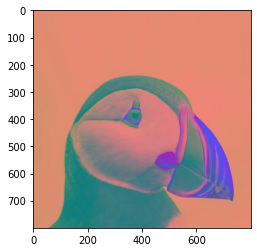

In [35]:
plt.imshow(idct_img.astype(np.int64))

# Converting YCbCr to RGB

In [36]:
def convert_ycbcr_to_rgb(ycbcr_image):
    y, cb, cr = ycbcr_image[:,:,0], ycbcr_image[:,:,1], ycbcr_image[:,:,2]
    y_data = np.array(y)
    cb_data = np.array(cb)
    cr_data = np.array(cr)
    r_data = y_data + 1.402 * (cr_data - 128)
    g_data = y_data - 0.344136 * (cb_data - 128) - 0.714136 * (cr_data - 128)
    b_data = y_data + 1.772 * (cb_data - 128)
    r_data = np.clip(r_data, 0, 255).astype(np.uint8)
    g_data = np.clip(g_data, 0, 255).astype(np.uint8)
    b_data = np.clip(b_data, 0, 255).astype(np.uint8)
    rgb_img = np.stack((r_data, g_data, b_data), axis=-1)
    return rgb_img

In [37]:
rgb_idct_img=convert_ycbcr_to_rgb(idct_img)

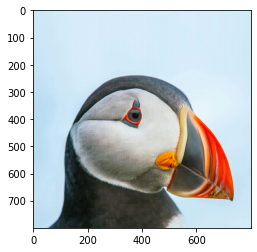

In [38]:
plt.imshow(rgb_idct_img.astype(np.int64))

# All at once function:

In [39]:
def compress_with_huffman_coding(img):
    newimg=convert_rgb_to_ycbcr(img)
    dct_img=dct_on_image(newimg)
    quantization_matrix=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            quantization_matrix[i][j]=2+2*i+j*2+1
    quantized_dct_img=quantize(dct_img)
    freqs=get_freqs_dict(quantized_dct_img.flatten())
    huffman_tree=build_huffman_tree(freqs)
    codewords = generate_codewords(huffman_tree)
    compressed_img=compress_image(quantized_dct_img.flatten(), codewords)
    decompressed_img=decompress_image(compressed_img,huffman_tree)
    decompressed_img=np.array(decompressed_img).reshape(quantized_dct_img.shape)
    decompressed_dequantized_img=dequantize(decompressed_img)
    idct_img=idct_on_image(decompressed_dequantized_img)
    final_decompressed_img=convert_ycbcr_to_rgb(idct_img)
    return compressed_img,final_decompressed_img

In [40]:
myimg=Image.open("slider_puffin_before_mobile.jpg")

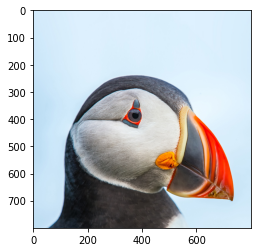

In [41]:
plt.imshow(myimg)

In [42]:
compressed,decompressed=compress_with_huffman_coding(myimg)

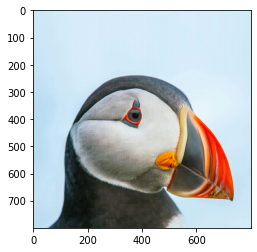

In [43]:
plt.imshow(decompressed)